# Repurchasers Analysis

Goal: Identify whether a user is a repurchaser or not, i.e. a potential returning customer

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
!pip install imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
%cd "/content/drive/Shareddrives/SIADS - 694-695 Team Drive/python-files"
!ls -l

/content/drive/Shareddrives/SIADS - 694-695 Team Drive/python-files
total 811
-rw------- 1 root root  11043 May 30 18:23 a1_likelihood_model.py
-rw------- 1 root root  13148 May 31 03:53 a1_model_training.py
-rw------- 1 root root  19759 May 30 19:17 a2_model_training.py
-rw------- 1 root root  47838 May 25 19:39 B2_B1_clustering_code.py
-rw------- 1 root root  47276 May 25 20:27 B2_B1_model_training.py
-rw------- 1 root root   1577 May 20 00:04 clean_dataset.py
-rw------- 1 root root   2434 May 12 00:19 create_sample_dataset.py
-rw------- 1 root root   2988 May 15 00:57 data_extraction.py
-rw------- 1 root root  20393 May 26 15:25 data_prep.py
-rw------- 1 root root      0 Apr 23 23:30 data_preprocessing.py
-rw------- 1 root root   1005 May 20 00:44 data_vis.py
-rw------- 1 root root   1919 May 30 18:55 Makefile
-rw------- 1 root root 637582 May 31 03:25 orchestrator.ipynb
drwx------ 2 root root   4096 May 11 04:15 __pycache__
-rw------- 1 root root    345 May 30 19:15 requirements.tx

In [16]:
!ls -l ../datasets/model_files/

total 22955
-rw------- 1 root root  9845241 May 14 17:18 A1_B2_data.csv
-rw------- 1 root root 10966769 May 14 17:18 A1_B2_data_dropped_features.csv
-rw------- 1 root root  1076172 May 14 17:18 A2_return_data.csv
-rw------- 1 root root  1611946 May 14 17:18 B1_rfm_data.csv
-rw------- 1 root root     4927 May 14 17:18 changes_made.csv


In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm

sns.set_style("darkgrid")
RANDOM_SEED = 655

In [19]:
df = pd.read_csv("../datasets/model_files/A2_return_data.csv")


In [20]:
df.columns

Index(['date', 'fullVisitorId', 'socialEngagementType', 'totals.hits',
       'totals.pageviews', 'totals.timeOnSite', 'device.browser_woe',
       'geoNetwork.country_woe', 'trafficSource.source_woe',
       'totals.transactions', 'hits.eCommerceAction.action_type',
       'hits.hour_ordinal', 'totals.newVisits', 'totals.bounces',
       'channelGrouping_Direct', 'channelGrouping_Display',
       'channelGrouping_Organic Search', 'channelGrouping_Paid Search',
       'channelGrouping_Referral', 'channelGrouping_Social',
       'trafficSource.medium_affiliate', 'trafficSource.medium_cpc',
       'trafficSource.medium_cpm', 'trafficSource.medium_organic',
       'trafficSource.medium_referral', 'trafficSource.isTrueDirect_code',
       'device.operatingSystem_Android', 'device.operatingSystem_BlackBerry',
       'device.operatingSystem_Chrome OS', 'device.operatingSystem_Firefox OS',
       'device.operatingSystem_Linux', 'device.operatingSystem_Macintosh',
       'device.operatingSyste

# Feature Selection

In [21]:
X = df.iloc[:,0:-1]  # independent columns
y = df.iloc[:,-1]    # target column repurchasers

In [22]:
X.columns

Index(['date', 'fullVisitorId', 'socialEngagementType', 'totals.hits',
       'totals.pageviews', 'totals.timeOnSite', 'device.browser_woe',
       'geoNetwork.country_woe', 'trafficSource.source_woe',
       'totals.transactions', 'hits.eCommerceAction.action_type',
       'hits.hour_ordinal', 'totals.newVisits', 'totals.bounces',
       'channelGrouping_Direct', 'channelGrouping_Display',
       'channelGrouping_Organic Search', 'channelGrouping_Paid Search',
       'channelGrouping_Referral', 'channelGrouping_Social',
       'trafficSource.medium_affiliate', 'trafficSource.medium_cpc',
       'trafficSource.medium_cpm', 'trafficSource.medium_organic',
       'trafficSource.medium_referral', 'trafficSource.isTrueDirect_code',
       'device.operatingSystem_Android', 'device.operatingSystem_BlackBerry',
       'device.operatingSystem_Chrome OS', 'device.operatingSystem_Firefox OS',
       'device.operatingSystem_Linux', 'device.operatingSystem_Macintosh',
       'device.operatingSyste

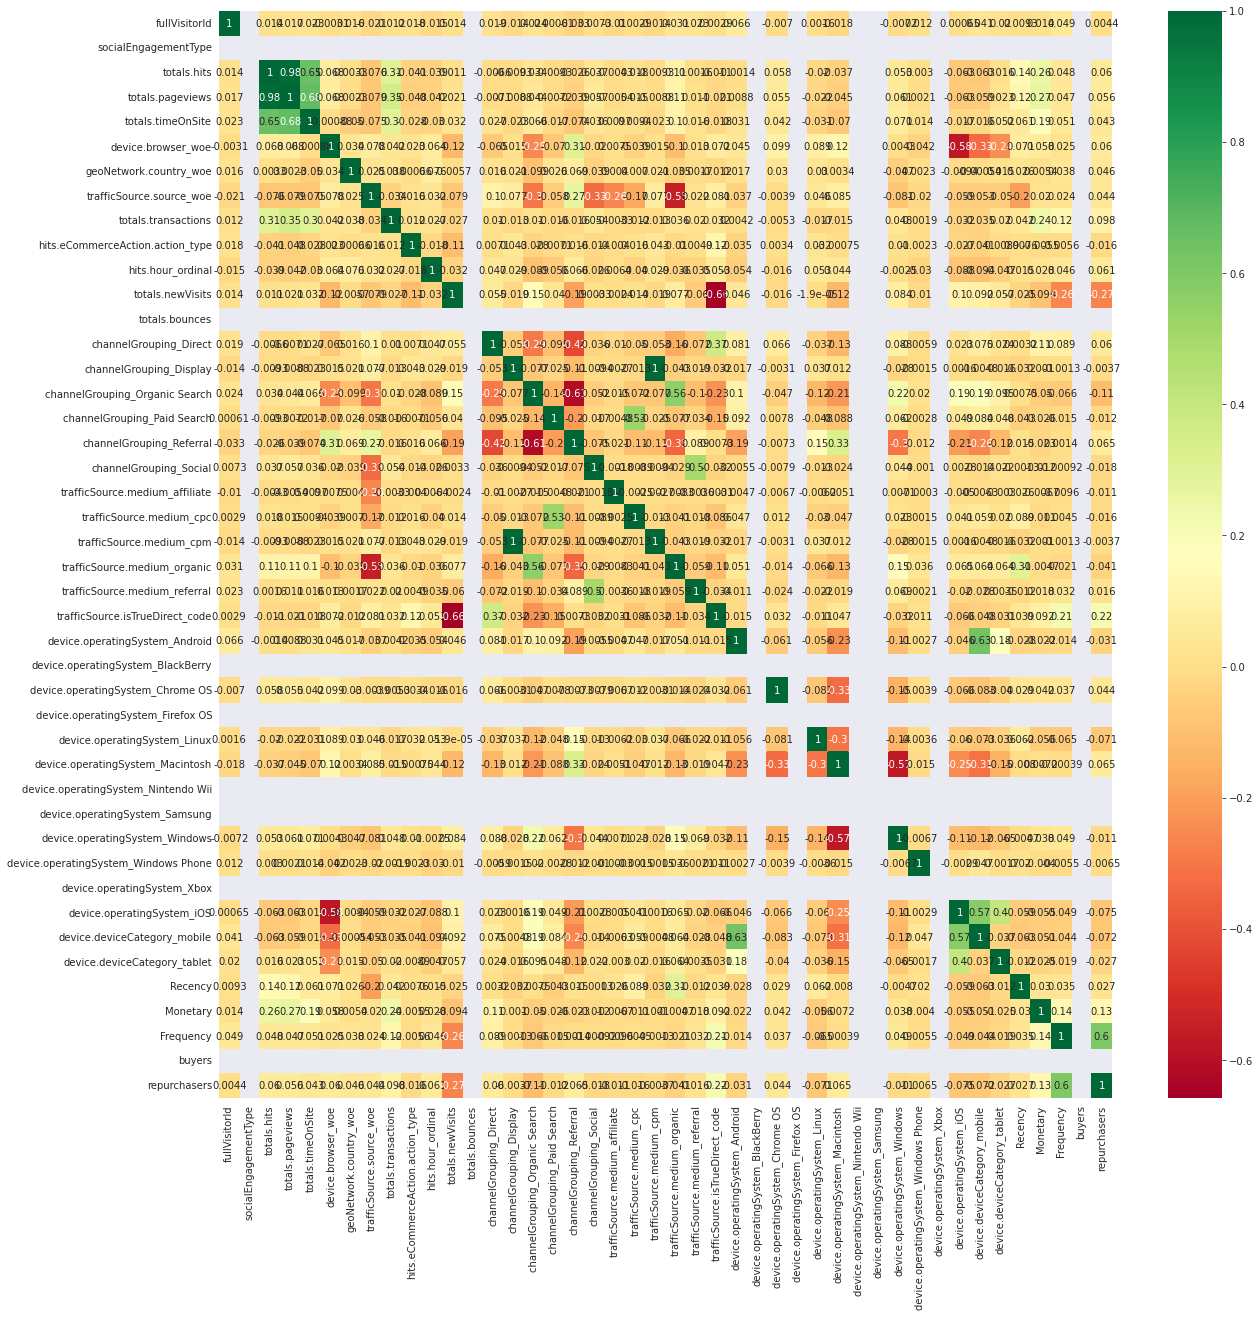

In [23]:
corrmat = df.dropna().corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g = sns.heatmap(
  df[top_corr_features].dropna().corr(),
  annot=True,
  cmap="RdYlGn"
)
fig = g.get_figure()
fig.savefig("../visualizations/a2_feature_correlation_heatmap.png") 

# Default Models

In [24]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [25]:
features = [
  'socialEngagementType',
  'totals.hits',
  'totals.pageviews',
  'totals.timeOnSite',
  'device.browser_woe',
  'geoNetwork.country_woe',
  'trafficSource.source_woe',
  'totals.transactions',
  'hits.eCommerceAction.action_type',
  'hits.hour_ordinal',
  'totals.newVisits',
  'totals.bounces',
  'channelGrouping_Direct',
  'channelGrouping_Display',
  'channelGrouping_Organic Search',
  'channelGrouping_Paid Search',
  'channelGrouping_Referral',
  'channelGrouping_Social',
  'trafficSource.medium_affiliate',
  'trafficSource.medium_cpc',
  'trafficSource.medium_cpm',
  'trafficSource.medium_organic',
  'trafficSource.medium_referral',
  'trafficSource.isTrueDirect_code',
  'device.operatingSystem_Android',
  'device.operatingSystem_BlackBerry',
  'device.operatingSystem_Chrome OS',
  'device.operatingSystem_Firefox OS',
  'device.operatingSystem_Linux',
  'device.operatingSystem_Macintosh',
  'device.operatingSystem_Nintendo Wii',
  'device.operatingSystem_Samsung',
  'device.operatingSystem_Windows',
  'device.operatingSystem_Windows Phone',
  'device.operatingSystem_Xbox',
  'device.operatingSystem_iOS',
  'device.deviceCategory_mobile',
  'device.deviceCategory_tablet',
  'Recency',
  'Monetary',
  'Frequency',
  'buyers'
]

In [26]:
df_input = df.dropna()
X = df_input[features]  # independent columns
y = df_input.iloc[:,-1]    # target column: repurchasers
X_train, X_test, y_train, y_test = train_test_split(
  X,
  y, 
  random_state=RANDOM_SEED
)

In [27]:
def report_output(y_test, y_pred, print_info=True):
  """
  Reporting General Output
  """
  model_roc_auc_score = metrics.roc_auc_score(y_test, y_pred)
  model_f1_score = metrics.f1_score(y_test, y_pred)

  if print_info:
    print(metrics.classification_report(y_test, y_pred))
    print("roc_auc_score: ", model_roc_auc_score)
    print("f1 score: ", model_f1_score)

  return model_roc_auc_score, model_f1_score

In [28]:
def report_model_feature_importance(features, feature_importances):
  """
  Report feature importances from a given model
  """
  features_and_importances = list(zip(features, feature_importances))
  features_and_importances = sorted(features_and_importances, key=lambda x: -x[1])
  
  temp_res = {'feature': [], 'importance': []}
  for feature_name, feature_importance in features_and_importances:
    print(feature_name, feature_importance)
    temp_res['feature'].append(feature_name)
    temp_res['importance'].append(feature_importance)

  return temp_res

In [29]:
def plot_roc_auc_and_f1_scores(
    roc_auc_scores,
    f1_scores,
    classifier_labels,
    chart_title="Chart TItle",
    save_figure_path="../visualizations/a2_figure.png",
  ):
  """
  Plots the given ROC - AUC and F1 Scores
  """
  fig = plt.figure()
  
  # set width of bar
  barWidth = 0.25
  fig = plt.subplots(figsize=(24, 8))
  # plt.grid(axis='x')
  # plt.grid(axis='y')
  plt.grid(True)
  # plt.gca().xaxis.grid()
  # plt.gca().yaxis.grid()
  
  # set height of bar
  plt.ylim(0, 1)
  
  # Set position of bar on X axis
  br1 = np.arange(len(roc_auc_scores))
  br2 = [x + barWidth for x in br1]
  
  # Make the plot
  plt.bar(
    br1,
    roc_auc_scores, 
    color='green',
    width=barWidth,
    # edgecolor='grey',
    alpha=0.5,
    label='ROC AUC Score',
    zorder=3
  )
  plt.bar(
    br2,
    f1_scores,
    color='y',
    width=barWidth,
    # edgecolor='grey',
    alpha=0.5,
    label='F1 Score',
    zorder=3
  )

  # for i, v in enumerate(roc_auc_scores):
  #   plt.text(i + .25, v + 3, str(v), color='blue', fontweight='bold')
  
  # Adding Xticks
  plt.xlabel('Classifiers', fontweight='bold', fontsize=25)
  plt.ylabel('Scores', fontweight='bold', fontsize=25)
  plt.xticks(
    [r + barWidth/2 for r in range(len(roc_auc_scores))],
    classifier_labels
  )
  plt.title(chart_title, fontweight='bold', fontsize=25)
  
  plt.legend(fontsize=20, facecolor="white", loc="upper left")

  plt.savefig(save_figure_path)
  plt.show()

In [30]:
def write_res_to_csv(
    roc_auc_scores,
    f1_scores,
    classifier_labels,
    save_result_path="../results/a2_figure.png", 
  ):
  """
  Writes the results into a CSV
  """
  res_dict = {
      "Classifier": classifier_labels,
      "ROC AUC Scores": roc_auc_scores,
      "F1 Scores": f1_scores,
  }

  df_res = pd.DataFrame.from_dict(res_dict)
  df_res.to_csv(save_result_path)

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

classifiers = {
  'Dummy Classifier (Stratified)': DummyClassifier(
    strategy='stratified',
    random_state=RANDOM_SEED
  ),
  'Dummy Classifier (uniform)': DummyClassifier(
    strategy='uniform',
    random_state=RANDOM_SEED
  ),
  'Dummy Classifier (most frequent)': DummyClassifier(
    strategy='most_frequent',
    random_state=RANDOM_SEED
  ),
  'Logistic Regression': LogisticRegression(
    max_iter=10000,
    random_state=RANDOM_SEED
  ),
  'SVC': SVC(
    random_state=RANDOM_SEED
  ),
  'KNN': KNeighborsClassifier(),
  'Decision Trees': DecisionTreeClassifier(
    random_state=RANDOM_SEED   
  ),
  'Random Forests': RandomForestClassifier(
    random_state=RANDOM_SEED   
  )
}

In [32]:
%%time
# fig = plt.figure()

roc_auc_scores = []
f1_scores = []

for clf_name, clf_model in classifiers.items():
  clf = clf_model.fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  model_roc_auc_score, model_f1_score = report_output(y_test, y_pred, print_info=False)
  roc_auc_scores.append(model_roc_auc_score)
  f1_scores.append(model_f1_score)


CPU times: user 4.55 s, sys: 1.98 s, total: 6.54 s
Wall time: 4.22 s


<Figure size 432x288 with 0 Axes>

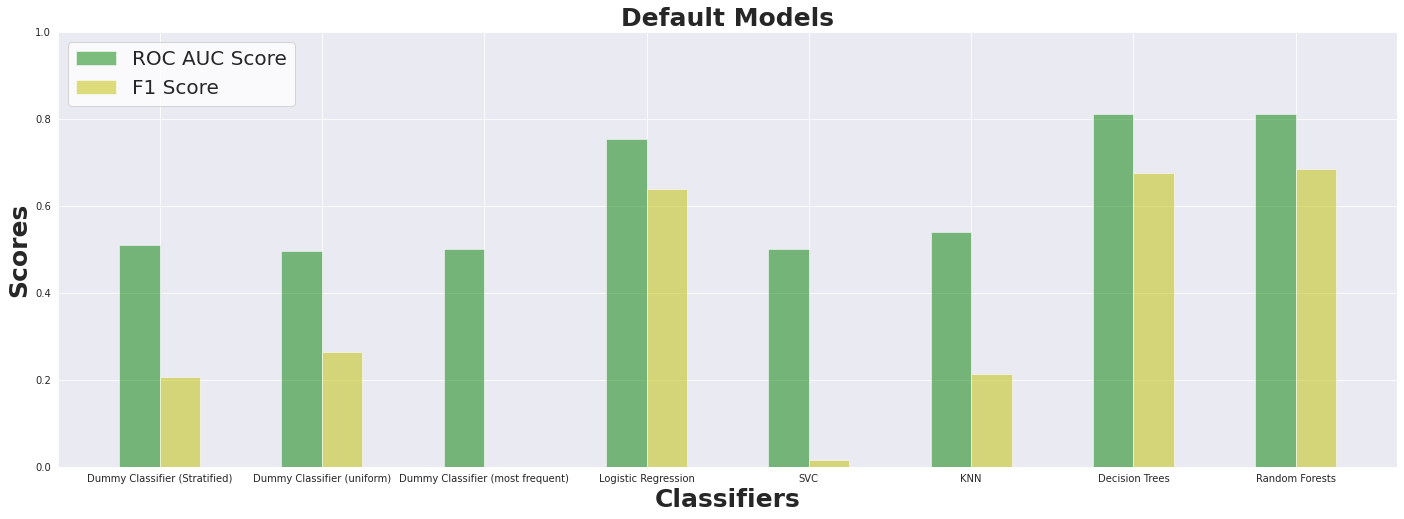

In [33]:
plot_roc_auc_and_f1_scores(
  roc_auc_scores,
  f1_scores,
  list(classifiers.keys()),
  chart_title="Default Models",
  save_figure_path="../visualizations/a2_default_models.png"
)

In [34]:
write_res_to_csv(
  roc_auc_scores,
  f1_scores,
  list(classifiers.keys()),
  save_result_path="../results/a2_default_models_results.csv"
)

Let's try out the model's with KFold to verify whether our model
can generalize across different training and test data.

In [35]:
%%time
from sklearn.model_selection import cross_val_score

performance_results = {}

for clf_name, clf_model in classifiers.items():
  scores = cross_val_score(
    clf_model, 
    X, 
    y, 
    cv=5, 
    scoring='f1_macro'
  )
  performance_results[clf_name] = scores
  print(f"{clf_name} F1 Scores:", scores)

Dummy Classifier (Stratified) F1 Scores: [0.50720167 0.49370034 0.5126022  0.48559955 0.49682114]
Dummy Classifier (uniform) F1 Scores: [0.43477212 0.46016003 0.45644341 0.46387666 0.44816167]
Dummy Classifier (most frequent) F1 Scores: [0.44533838 0.44507576 0.44507576 0.44507576 0.44528659]
Logistic Regression F1 Scores: [0.7955804  0.81538732 0.82679983 0.81601442 0.7734212 ]
SVC F1 Scores: [0.44533838 0.45657557 0.45531303 0.44507576 0.44528659]
KNN F1 Scores: [0.53680678 0.50461635 0.57113583 0.5483542  0.5158816 ]
Decision Trees F1 Scores: [0.75799808 0.80072605 0.77781211 0.81131895 0.7467323 ]
Random Forests F1 Scores: [0.72944717 0.84939035 0.85067906 0.84266124 0.76453741]
CPU times: user 21.3 s, sys: 8.39 s, total: 29.7 s
Wall time: 19.5 s


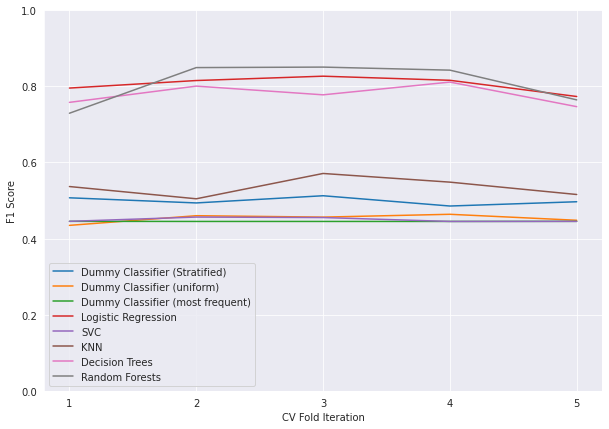

In [36]:
plt.figure(figsize=(10, 7))

for key, scores in performance_results.items():
  plt.plot(list(range(1, 6)), scores, label=key)

plt.ylim(0, 1)
plt.ylabel("F1 Score")
plt.xlabel("CV Fold Iteration")
plt.xticks(list(range(1, 6)))
plt.legend()
plt.savefig("../visualizations/a2_kfold_analysis.png")
plt.show()
  

We can see that the default Decision Trees and Random Forests appear to perform
the best with near identical ROC AUC and F1 Scores.
Second best is the Logistic Regression model.

Let's see how well the models perform after conducting:
1. Parameter Finetuning via Grid Search
2. Balancing the Dataset
3. Combining both approaches


## Some more individual runs, if interested

In [ ]:
%%time
# Logistic Regression
from sklearn.linear_model import LogisticRegression

log_reg_clf = LogisticRegression(
  max_iter=10000,
  random_state=RANDOM_SEED
)
log_reg_clf.fit(X_train, y_train)

CPU times: user 2.56 s, sys: 1.77 s, total: 4.33 s
Wall time: 2.27 s


In [ ]:
y_pred_reg_log = log_reg_clf.predict(X_test)
report_output(y_test, y_pred_reg_log)

              precision    recall  f1-score   support

           0       0.91      0.97      0.93      1202
           1       0.77      0.54      0.64       263

    accuracy                           0.89      1465
   macro avg       0.84      0.75      0.79      1465
weighted avg       0.88      0.89      0.88      1465

roc_auc_score:  0.7543922360071618
f1 score:  0.6383928571428571


(0.7543922360071618, 0.6383928571428571)

In [ ]:
%%time
# SVC
from sklearn.svm import SVC

svc_clf = SVC(
  random_state=RANDOM_SEED
)
svc_clf.fit(X_train, y_train)

CPU times: user 944 ms, sys: 69.8 ms, total: 1.01 s
Wall time: 941 ms


In [ ]:
y_pred_svc = svc_clf.predict(X_test)
report_output(y_test, y_pred_svc)

              precision    recall  f1-score   support

           0       0.82      0.99      0.90      1202
           1       0.18      0.01      0.01       263

    accuracy                           0.82      1465
   macro avg       0.50      0.50      0.46      1465
weighted avg       0.71      0.82      0.74      1465

roc_auc_score:  0.5000585209694869
f1 score:  0.014598540145985401


(0.5000585209694869, 0.014598540145985401)

In [ ]:
%%time
# KNN
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

CPU times: user 6.12 ms, sys: 414 µs, total: 6.54 ms
Wall time: 5.56 ms


In [ ]:
y_pred_knn = knn_clf.predict(X_test)
report_output(y_test, y_pred_knn)

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1202
           1       0.29      0.17      0.21       263

    accuracy                           0.78      1465
   macro avg       0.56      0.54      0.54      1465
weighted avg       0.74      0.78      0.75      1465

roc_auc_score:  0.5395570120774628
f1 score:  0.21307506053268763


(0.5395570120774628, 0.21307506053268763)

In [ ]:
# Decision Trees
%%time
from sklearn.tree import DecisionTreeClassifier

dec_tree_clf = DecisionTreeClassifier(
  random_state=RANDOM_SEED   
)
dec_tree_clf.fit(X_train, y_train)

CPU times: user 20.8 ms, sys: 3.19 ms, total: 24 ms
Wall time: 24.5 ms


In [ ]:
y_pred_dec_tree = dec_tree_clf.predict(X_test)
report_output(y_test, y_pred_dec_tree)

              precision    recall  f1-score   support

           0       0.93      0.92      0.93      1202
           1       0.65      0.70      0.68       263

    accuracy                           0.88      1465
   macro avg       0.79      0.81      0.80      1465
weighted avg       0.88      0.88      0.88      1465

roc_auc_score:  0.8105296622232906
f1 score:  0.6764168190127972


(0.8105296622232906, 0.6764168190127972)

In [ ]:
# dt_feature_importances = list(dec_tree_clf.feature_importances_)
# report_model_feature_importance(features, dt_feature_importances)

In [ ]:
# Random Forests
%%time
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(
  random_state=RANDOM_SEED   
)
rf_clf.fit(X_train, y_train)

CPU times: user 487 ms, sys: 8 ms, total: 495 ms
Wall time: 496 ms


In [ ]:
y_pred_rf_clf = rf_clf.predict(X_test)
report_output(y_test, y_pred_rf_clf)

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      1202
           1       0.68      0.70      0.69       263

    accuracy                           0.89      1465
   macro avg       0.80      0.81      0.81      1465
weighted avg       0.89      0.89      0.89      1465

roc_auc_score:  0.8113030880092115
f1 score:  0.6853932584269662


(0.8113030880092115, 0.6853932584269662)

In [ ]:
# feature_importances = list(rf_clf.feature_importances_)
# report_model_feature_importance(features, feature_importances)

# Finetuning

So far we've only been using default params. 
We will finetune by using grid search techniques

In [37]:
import warnings
# Grid Search has a lot of Warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import GridSearchCV

grid_search_classifiers = {
  'Dummy Classifier (Stratified)': {
    "model": DummyClassifier(
      strategy='stratified',
      random_state=RANDOM_SEED
    ),
    "param_grid": {}
  },
  'Dummy Classifier (uniform)': {
    "model": DummyClassifier(
      strategy='uniform',
      random_state=RANDOM_SEED
    ),
    "param_grid": {}
  },
  'Dummy Classifier (most frequent)': {
    "model": DummyClassifier(
      strategy='most_frequent',
      random_state=RANDOM_SEED
    ),
    "param_grid": {}
  },
  'Logistic Regression': {
    "model": LogisticRegression(
      max_iter=10000,
      random_state=RANDOM_SEED
    ),
    "param_grid": {
      'penalty': ['l1','l2'],
      'C': [0.01, 0.1, 1, 10, 100, 1000],
      'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    }
  },
  'SVC': {
    "model": SVC(
      random_state=RANDOM_SEED
    ),
    "param_grid": {
      'C': [0.1, 1, 10, 100], 
      'gamma': [1, 0.1, 0.01, 0.001],
      'kernel': ['rbf', 'sigmoid'] # Removing Polynomial as it took 1+ hour per run
    }
  },
  'KNN': {
    "model": KNeighborsClassifier(),
    "param_grid": {
      'n_neighbors': [3, 5, 15, 25, 30],
      'weights': ['uniform', 'distance'],
      'metric': ['euclidean', 'manhattan'],
    },
  },
  'Decision Trees': {
    "model": DecisionTreeClassifier(
      random_state=RANDOM_SEED   
    ),
    "param_grid": {
      'criterion': ['gini', 'entropy'],
      'max_depth' : [None, 5, 10, 15, 30],
      'min_samples_split': [2, 4, 6, 8, 10],
      'min_samples_leaf': [1, 3, 5],
    }
  },
  'Random Forests': {
    "model": RandomForestClassifier(
      random_state=RANDOM_SEED   
    ),
    "param_grid": {
      'criterion': ['gini', 'entropy'],
      'max_depth': [None, 5, 10, 15, 30],
      'n_estimators': [200, 500],
      'max_features': ['sqrt', 'log2'],
    }
  },
}

In [38]:
# %%time
# finetuned_roc_auc_scores = []
# finetuned_f1_scores = []
# clf_best_params = {}
# 
# for clf_name, clf_info in grid_search_classifiers.items():
#   print("Beginning", clf_name)
#   clf_model = clf_info["model"]
#   param_grid = clf_info["param_grid"]
# 
#   clf = GridSearchCV(
#     clf_model,
#     param_grid,
#     scoring='f1_macro',
#   )
#   clf.fit(X_train, y_train)
# 
#   clf_best_params[clf_name] = clf.best_params_
# 
#   # Using the best parameters, let's get the ROC/AUC and F1 Scores
#   y_pred = clf.predict(X_test)
#   model_roc_auc_score, model_f1_score = report_output(y_test, y_pred, print_info=False)
#   finetuned_roc_auc_scores.append(model_roc_auc_score)
#   finetuned_f1_scores.append(model_f1_score)
# 

In [39]:
def grid_search_clf_runs(grid_search_classifiers, X, y):
  """
  Runs the grid search classifiers on a given X and y
  """
  X_train, X_test, y_train, y_test = train_test_split(
    X,
    y, 
    random_state=RANDOM_SEED
  )

  finetuned_roc_auc_scores = []
  finetuned_f1_scores = []
  clf_best_params = {}
  
  for clf_name, clf_info in grid_search_classifiers.items():
    print("Beginning", clf_name)
    clf_model = clf_info["model"]
    param_grid = clf_info["param_grid"]
  
    clf = GridSearchCV(
      clf_model,
      param_grid,
      scoring='f1_macro',
    )
    clf.fit(X_train, y_train)
  
    clf_best_params[clf_name] = clf.best_params_
  
    # Using the best parameters, let's get the ROC/AUC and F1 Scores
    y_pred = clf.predict(X_test)
    model_roc_auc_score, model_f1_score = report_output(y_test, y_pred, print_info=False)
    finetuned_roc_auc_scores.append(model_roc_auc_score)
    finetuned_f1_scores.append(model_f1_score)

  return finetuned_roc_auc_scores, finetuned_f1_scores, clf_best_params

In [40]:
%%time
df_input = df.dropna()
X = df_input[features]  # independent columns
y = df_input.iloc[:,-1]    # target column: repurchasers

finetuned_roc_auc_scores, finetuned_f1_scores, clf_best_params = \
  grid_search_clf_runs(grid_search_classifiers, X, y)

Beginning Dummy Classifier (Stratified)
Beginning Dummy Classifier (uniform)
Beginning Dummy Classifier (most frequent)
Beginning Logistic Regression
Beginning SVC
Beginning KNN
Beginning Decision Trees
Beginning Random Forests
CPU times: user 8min 51s, sys: 1min 22s, total: 10min 14s
Wall time: 9min 2s


<Figure size 432x288 with 0 Axes>

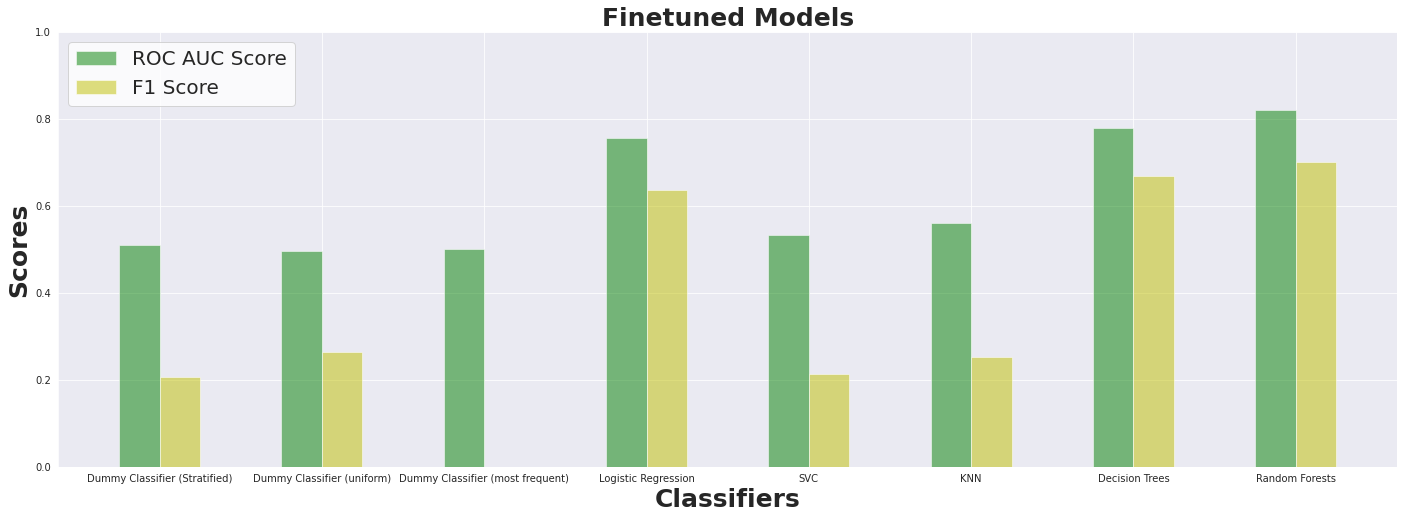

In [41]:
plot_roc_auc_and_f1_scores(
  finetuned_roc_auc_scores,
  finetuned_f1_scores,
  list(grid_search_classifiers.keys()),
  chart_title="Finetuned Models",
  save_figure_path="../visualizations/a2_finetuned_models.png"
)

In [42]:
write_res_to_csv(
  finetuned_roc_auc_scores,
  finetuned_f1_scores,
  list(grid_search_classifiers.keys()),
  save_result_path="../results/a2_finetuned_models_results_not_balanced.csv"
)

In [43]:
clf_best_params

{'Decision Trees': {'criterion': 'gini',
  'max_depth': 5,
  'min_samples_leaf': 1,
  'min_samples_split': 2},
 'Dummy Classifier (Stratified)': {},
 'Dummy Classifier (most frequent)': {},
 'Dummy Classifier (uniform)': {},
 'KNN': {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'},
 'Logistic Regression': {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'},
 'Random Forests': {'criterion': 'entropy',
  'max_depth': 15,
  'max_features': 'sqrt',
  'n_estimators': 500},
 'SVC': {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}}

Interesting, we noticed that there isn't much improvement when using the GridSearch optimal parameters, compared to when using the default model parameters. Let's see if we can improve it by rebalancing the dataset's target class.

# Balancing Classes on the Datasets

We will use SMOTE to rebalance the dataset.

In [44]:
from imblearn.over_sampling import SMOTE

def class_rebalance(df, features, target_class):
  X = df[features]
  y = df[target_class]
  
  # rebalance
  smote = SMOTE(random_state=RANDOM_SEED)
  # fit predictor and target variable
  X_smote, y_smote = smote.fit_resample(X, y)
  
  fig = plt.figure()
  fig.set_size_inches(8, 3)

  ax1 = plt.subplot(121)
  ax1 = sns.countplot(df[target_class])
  ax1.set_xlabel("Repurchasers", fontsize=12)
  ax1.set_xticklabels(['0', '1'])
  ax1.set_ylabel("Count", fontsize=12)
  ax1.set_title("Before rebalancing", fontsize=14)
  ax1.set_facecolor('#EAEAF2')
  
  ax2 = plt.subplot(122)
  ax2 = sns.countplot(y_smote)
  ax2.set_xlabel("Repurchasers", fontsize=12)
  ax2.set_xticklabels(['0', '1'])
  ax2.set_ylabel(" ", fontsize=12)
  ax2.set_title("After rebalancing", fontsize=14)
  ax2.set_facecolor('#EAEAF2')
  
  
  fig.savefig('../visualizations/rebalanced_repurchasers.png', bbox_inches='tight')
  
  rebalanced_df = pd.concat([X_smote, y_smote], axis=1)

  return rebalanced_df

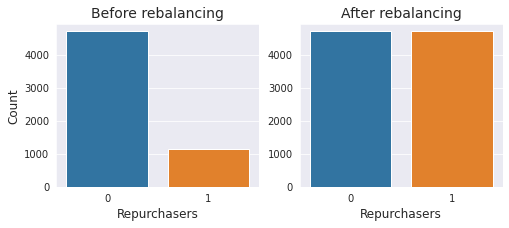

In [45]:
df_rebalanced = class_rebalance(df.dropna(), features, "repurchasers")

In [46]:
df_rebalanced

,socialEngagementType,totals.hits,totals.pageviews,totals.timeOnSite,device.browser_woe,geoNetwork.country_woe,trafficSource.source_woe,totals.transactions,hits.eCommerceAction.action_type,hits.hour_ordinal,...,device.operatingSystem_Windows Phone,device.operatingSystem_Xbox,device.operatingSystem_iOS,device.deviceCategory_mobile,device.deviceCategory_tablet,Recency,Monetary,Frequency,buyers,repurchasers
0,0,20,17.000000,414.000000,-1.246226,0.947358,-0.008709,1.0,0,0,...,0,0,0,0,0,30,5.000000,1,1,0
1,0,21,15.000000,563.000000,-1.246226,0.947358,-0.008709,1.0,0,1,...,0,0,0,0,0,30,28.000000,2,1,0
2,0,25,25.000000,764.000000,0.303441,0.947358,-0.008709,1.0,0,1,...,0,0,0,0,0,30,63.000000,2,1,0
3,0,25,23.000000,608.000000,0.303441,0.947358,-0.008709,1.0,0,1,...,0,0,0,0,0,30,31.000000,1,1,0
4,0,52,46.000000,1113.000000,0.303441,0.947358,0.600577,1.0,0,2,...,0,0,0,0,0,30,44.600000,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9397,0,26,21.003924,1394.464937,0.303441,1.316752,0.126954,1.0,0,1,...,0,0,0,0,0,163,43.875772,4,1,1
9398,0,67,48.978504,2156.408415,0.303441,0.947358,0.600577,1.0,0,1,...,0,0,0,0,0,58,460.477310,2,1,1
9399,0,51,33.579857,1562.385589,0.303441,-2.880467,0.119285,1.0,0,2,...,0,0,0,0,0,127,126.121429,2,1,1
9400,0,57,42.962068,689.405728,0.303441,0.947358,0.600577,1.0,0,2,...,0,0,0,0,0,156,74.307475,2,1,1


In [47]:
%%time
df_rebalanced = df_rebalanced.dropna()
X = df_rebalanced[features]   # independent columns
y = df_rebalanced.iloc[:,-1]  # target column: repurchasers

rebalanced_roc_auc_scores, rebalanced_f1_scores, rebalanced_clf_best_params = \
  grid_search_clf_runs(grid_search_classifiers, X, y)

Beginning Dummy Classifier (Stratified)
Beginning Dummy Classifier (uniform)
Beginning Dummy Classifier (most frequent)
Beginning Logistic Regression
Beginning SVC
Beginning KNN
Beginning Decision Trees
Beginning Random Forests
CPU times: user 19min 18s, sys: 2min 18s, total: 21min 37s
Wall time: 18min 37s


<Figure size 432x288 with 0 Axes>

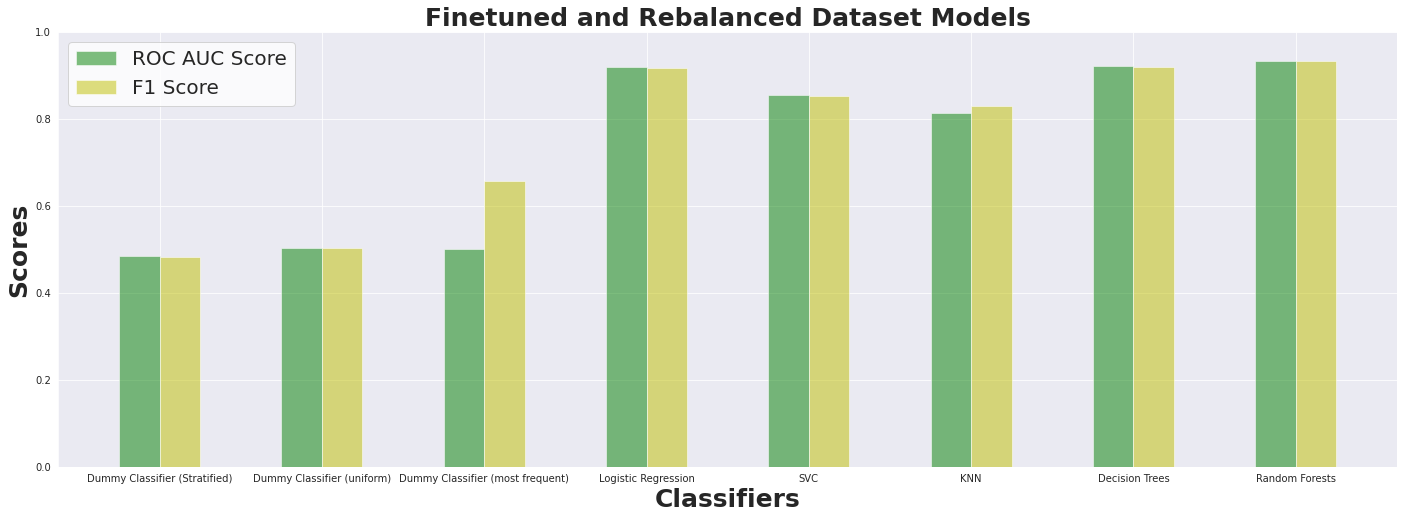

In [57]:
# plot_roc_auc_and_f1_scores(
#   rebalanced_roc_auc_scores,
#   rebalanced_f1_scores,
#   list(grid_search_classifiers.keys())
# )
plot_roc_auc_and_f1_scores(
  rebalanced_roc_auc_scores,
  rebalanced_f1_scores,
  list(grid_search_classifiers.keys()),
  chart_title="Finetuned and Rebalanced Dataset Models",
  save_figure_path="../visualizations/a2_finetuned_rebalanced_models_FINAL.png"
)

In [59]:
def plot_roc_auc_and_f1_scores_2(
    roc_auc_scores,
    f1_scores,
    classifier_labels,
    chart_title="Chart TItle",
    save_figure_path="../visualizations/a2_figure.png",
  ):
  """
  Plots the given ROC - AUC and F1 Scores
  """
  labels = classifier_labels
  roc = roc_auc_scores
  f1 = f1_scores

  x = np.arange(len(labels))  # the label locations
  width = 0.35  # the width of the bars

  fig, ax = plt.subplots()
  rects1 = ax.bar(x - width/2, roc, width, label='ROC')
  rects2 = ax.bar(x + width/2, f1, width, label='F1 scores')

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('Scores')
  ax.set_title('Scores by Model type')
  ax.set_xticks(x, labels)
  ax.legend()

  rects1 = ax.bar(x - width/2, roc, width, label='ROC')
  rects2 = ax.bar(x + width/2, f1, width, label='F1')
  ax.bar_label(rects1, padding=3)
  ax.bar_label(rects2, padding=3)
  
  ax.legend(fontsize=20, facecolor="white", loc="upper left")

  plt.show()



In [49]:
write_res_to_csv(
  rebalanced_roc_auc_scores,
  rebalanced_f1_scores,
  list(grid_search_classifiers.keys()),
  save_result_path="../results/a2_finetuned_rebalanced_models_results_FINAL.csv"
)

In [50]:
rebalanced_clf_best_params

{'Decision Trees': {'criterion': 'gini',
  'max_depth': 10,
  'min_samples_leaf': 5,
  'min_samples_split': 2},
 'Dummy Classifier (Stratified)': {},
 'Dummy Classifier (most frequent)': {},
 'Dummy Classifier (uniform)': {},
 'KNN': {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'},
 'Logistic Regression': {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'},
 'Random Forests': {'criterion': 'gini',
  'max_depth': 30,
  'max_features': 'log2',
  'n_estimators': 200},
 'SVC': {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}}

## Now let's just use the optimal params for our model

In [51]:
# Optimal Classifiers for Rebalanced Dataset:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

optimal_balanced_classifiers = {
  'Logistic Regression': {
    "model": LogisticRegression(
      max_iter=10000,
      random_state=RANDOM_SEED,
      C=10,
      penalty='l2',
      solver='lbfgs',
    ),
    "model_name": "a2_lr_model.pkl",
  },
  'SVC': {
    "model": SVC(
      random_state=RANDOM_SEED,
      C=100, 
      gamma=0.001,
      kernel='rbf',
    ),
    "model_name": "a2_svc_model.pkl",
  },
  'KNN': {
    "model": KNeighborsClassifier(
      n_neighbors=3,
      metric='manhattan',
      weights='distance',
    ),
    "model_name": "a2_knn_model.pkl",
  },
  'Decision Trees': {
    "model": DecisionTreeClassifier(
      random_state=RANDOM_SEED,
      criterion='gini',
      max_depth=10,
      min_samples_leaf=5,
      min_samples_split=2,
    ),
    "model_name": "a2_dt_model.pkl",
  },
  'Random Forests': {
    "model": RandomForestClassifier(
      random_state=RANDOM_SEED,
      criterion='gini',
      max_depth=30,
      max_features='log2',
      n_estimators=200,
    ),
    "model_name": "a2_rf_model.pkl",
  },
}

In [52]:
df_rebalanced = df_rebalanced.dropna()
X = df_rebalanced[features]   # independent columns
y = df_rebalanced.iloc[:,-1]  # target column: repurchasers

In [53]:
import pickle
import os
output_directory = "../models/"

In [54]:
%%time
X_train, X_test, y_train, y_test = train_test_split(
  X,
  y, 
  random_state=RANDOM_SEED
)
optimal_roc_auc_scores = []
optimal_f1_scores = []
optimal_clf_best_params = {}

for clf_name, clf_info in optimal_balanced_classifiers.items():
  print("Beginning", clf_name)
  clf = clf_info["model"].fit(X_train, y_train)

  model_filename = clf_info['model_name']
  model_savepath = f"{output_directory}/a2_models/"
  if not os.path.exists(model_savepath):
    os.mkdir(model_savepath)

  with open(f"{model_savepath}/{model_filename}", 'wb') as pkl_file:
    pickle.dump(clf, pkl_file)

  y_pred = clf.predict(X_test)

  # Using the best parameters, let's get the ROC/AUC and F1 Scores
  model_roc_auc_score, model_f1_score = report_output(y_test, y_pred, print_info=False)
  optimal_roc_auc_scores.append(model_roc_auc_score)
  optimal_f1_scores.append(model_f1_score)

Beginning Logistic Regression
Beginning SVC
Beginning KNN
Beginning Decision Trees
Beginning Random Forests
CPU times: user 20.3 s, sys: 5.72 s, total: 26 s
Wall time: 21.4 s


<Figure size 432x288 with 0 Axes>

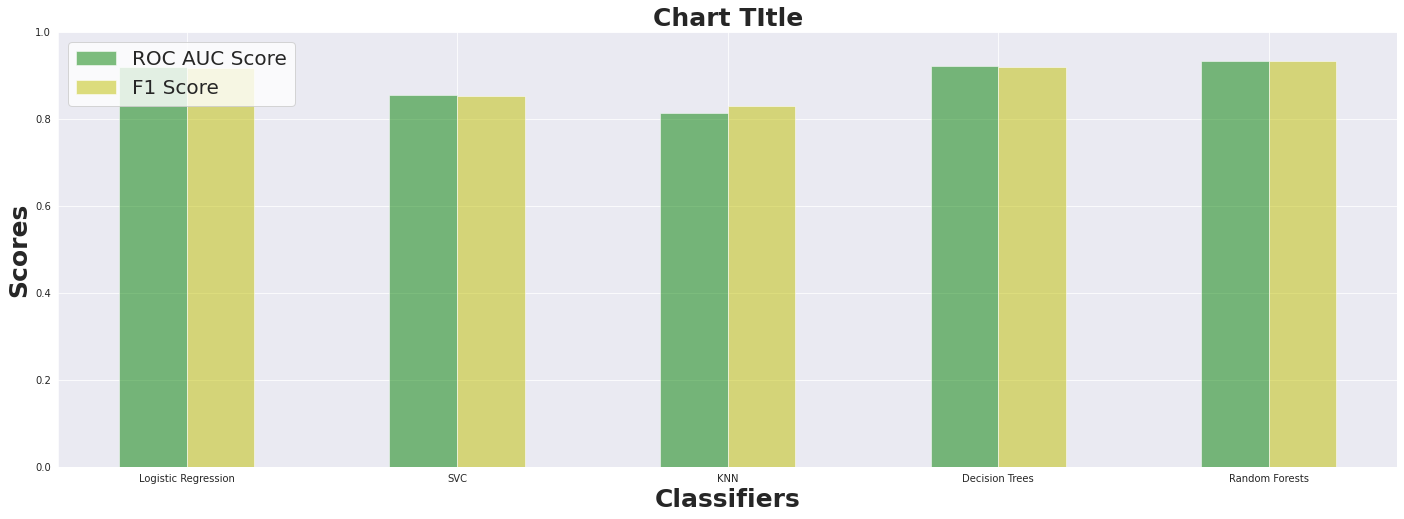

In [55]:
plot_roc_auc_and_f1_scores(
  optimal_roc_auc_scores,
  optimal_f1_scores,
  list(optimal_balanced_classifiers.keys())
)

In [56]:
write_res_to_csv(
  optimal_roc_auc_scores,
  optimal_f1_scores,
  list(optimal_balanced_classifiers.keys()),
  save_result_path="../results/a2_optimal_finetuned_rebalanced_models_results_only_best_models.csv"
)

Logistic Regression runtime: 
```
(0.9198486768272816, 0.9176882661996496)
CPU times: user 11.8 s, sys: 9.9 s, total: 21.7 s
Wall time: 18.2 s
```

SVC Runtime:
```
(0.8542113456177822, 0.8520914187149633)
CPU times: user 12.3 s, sys: 38.6 ms, total: 12.3 s
Wall time: 12.7 s
```

KNN Runtime:
```
(0.8146942765087065, 0.830130668716372)
CPU times: user 844 ms, sys: 5.97 ms, total: 849 ms
Wall time: 933 ms
```

Decision Trees Runtime:
```
(0.9205687289577527, 0.9204064352243859)
CPU times: user 56.1 ms, sys: 1.16 ms, total: 57.3 ms
Wall time: 60.8 ms
```

Random Forest Runtime:
```
(0.932882018607682, 0.9325985587113185)
CPU times: user 2.42 s, sys: 19.9 ms, total: 2.44 s
Wall time: 2.55 s
```

# Decision Trees with other Features

We explored "what is considered an important feature?" by using the SKLearns classifier's attribute `_feature_importances`

In [ ]:
import graphviz
from sklearn.tree import export_graphviz
import pydotplus

def plot_decision_tree(clf, feature_names, class_names):
  out_file_path = "../visualizations/adspy_temp.dot"
  export_graphviz(clf, out_file=out_file_path, feature_names=feature_names, class_names=class_names, filled=True, impurity=False)
  with open(out_file_path) as f:
      dot_graph = f.read()

  graph_obj = graphviz.Source(dot_graph)
  png_bytes = graph_obj.pipe(format='png')
  with open('../visualizations/dtree_pipe.png', 'wb') as f:
      f.write(png_bytes)
      
  return graph_obj

In [ ]:
df_rebalanced = df_rebalanced.dropna()
X = df_rebalanced[features]   # independent columns
y = df_rebalanced.iloc[:,-1]  # target column: repurchasers

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
  X,
  y, 
  random_state=RANDOM_SEED
)

optimal_dt_clf = optimal_balanced_classifiers["Decision Trees"]["model"].fit(X_train, y_train)

In [ ]:
len(features)

Recall, we were training on 42 features.
Let's see what the optimal Decision Tree model deems important by inspecting
the model's `feature_importances_` attribute.
Decision trees uses the `Gini Importance` or “mean decrease impurity” and is
defined as the total decrease in node impurity averaged over all trees of the ensemble, where values closer to 1 are important and 0 least important.

In [ ]:
dt_feature_importances = list(optimal_dt_clf.feature_importances_)
dt_feature_importance_dict = report_model_feature_importance(features, dt_feature_importances)

In [ ]:
feature_importance_df = pd.DataFrame.from_dict(dt_feature_importance_dict)
feature_importance_df.to_csv("../results/a2_feature_importance.csv")
feature_importance_df

There are a lot of features that have close to 0 importance.
Let's prune some of these non important features and see how well our Decision
Tree model can predict with just using these features.

For our use-case, we will prune all features with important less than `0.005`.

In [ ]:
def prune_model_feature_importance(
    features,
    feature_importances,
    threshold=0.005
  ):
  """
  Return the important features from a given model and a threshold
  """
  features_and_importances = list(zip(features, feature_importances))
  features_and_importances = sorted(features_and_importances, key=lambda x: -x[1])
  
  temp_res = {'feature': [], 'importance': []}
  new_features = []
  for feature_name, feature_importance in features_and_importances:
    if feature_importance >= threshold:
      print(feature_name, feature_importance)
      new_features.append(feature_name)
      temp_res['feature'].append(feature_name)
      temp_res['importance'].append(feature_importance)

  return new_features, temp_res

In [ ]:
dt_feature_importances = list(optimal_dt_clf.feature_importances_)
feature_subset, feature_subset_dict = prune_model_feature_importance(
  features,
  dt_feature_importances,
  threshold=0.01
)
feature_subset

In [ ]:
feature_subset_df = pd.DataFrame.from_dict(feature_subset_dict)
feature_subset_df.to_csv("../results/a2_top_features.csv")
feature_subset_df

In [ ]:
df_rebalanced = df_rebalanced.dropna()
X = df_rebalanced[feature_subset]   # independent columns
y = df_rebalanced.iloc[:,-1]  # target column: repurchasers

X_train, X_test, y_train, y_test = train_test_split(
  X,
  y, 
  random_state=RANDOM_SEED
)

feat_subset_optimal_dt_clf = optimal_balanced_classifiers["Decision Trees"]["model"].fit(X_train, y_train)

In [ ]:
%%time
feat_subset_optimal_roc_auc_scores = []
feat_subset_optimal_f1_scores = []
feat_subset_optimal_clf_best_params = {}

for clf_name, clf_info in optimal_balanced_classifiers.items():
  print("Beginning", clf_name)
  clf = clf_info["model"].fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  # Using the best parameters, let's get the ROC/AUC and F1 Scores
  model_roc_auc_score, model_f1_score = report_output(y_test, y_pred, print_info=False)
  feat_subset_optimal_roc_auc_scores.append(model_roc_auc_score)
  feat_subset_optimal_f1_scores.append(model_f1_score)

In [ ]:
# plot_roc_auc_and_f1_scores(
#   feat_subset_optimal_roc_auc_scores,
#   feat_subset_optimal_f1_scores,
#   list(optimal_balanced_classifiers.keys())
# )
plot_roc_auc_and_f1_scores(
  feat_subset_optimal_roc_auc_scores,
  feat_subset_optimal_f1_scores,
  list(optimal_balanced_classifiers.keys()),
  chart_title="Finetuned, Rebalanced Dataset, and Feature Pruned Models",
  save_figure_path="../visualizations/a2_finetuned_feature_pruned_models.png"
)

In [ ]:
write_res_to_csv(
  feat_subset_optimal_roc_auc_scores,
  feat_subset_optimal_f1_scores,
  list(optimal_balanced_classifiers.keys()),
  save_result_path="../results/a2_finetuned_feature_pruned_models_results.csv"
)

In [ ]:
# feat_subset_optimal_dt_clf = optimal_balanced_classifiers["Decision Trees"]["model"].fit(X_train, y_train)
plot_decision_tree(feat_subset_optimal_dt_clf, list(X.columns), ['Not Repurchaser', 'Repurchaser'])

In [ ]:
# Just for fun, let's see at a maximum depth of 5
dt_fun_clf = DecisionTreeClassifier(
  random_state=RANDOM_SEED,
  criterion='gini',
  max_depth=5,
  min_samples_leaf=5,
  min_samples_split=2,
).fit(X_train, y_train)

y_pred = dt_fun_clf.predict(X_test)

# Using the best parameters, let's get the ROC/AUC and F1 Scores
model_roc_auc_score, model_f1_score = report_output(y_test, y_pred, print_info=False)
print("ROC AUC Score", model_roc_auc_score)
print("F1 Score", model_f1_score)

In [ ]:
plot_decision_tree(dt_fun_clf, list(X.columns), ['Not Repurchaser', 'Repurchaser'])